# Машинное обучение, ФКН ВШЭ

# Практическое задание 7

## Общая информация

Дата выдачи: 11.05.2017

Срок сдачи: 23:59MSK 28.05.2017

### О задании

Практическое задание 7 посвящено задаче построения рекомендаций и различным подходам к её решению. В рамках данного задания вы:
 * опробуете различные подходы к построению рекомендаций в задаче рекомендаций фильмов;
 * оцените качество работы различных подходов на различных группах пользователей, изучите наличие известных недостатков рекомендательных систем;
 * познакомитесь со способами оценивания качества работы полученных рекомендательных систем, изучите их достоинства и недостатки.
 
### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW7_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW7_IvanovII.ipynb*). Далее отправьте этот файл на hse.cs.ml+<номер группы>@gmail.com (например, hse.cs.ml+141@gmail.com для студентов группы БПМИ-141).

## Рекомендательные системы

В этой лабораторной работе будет рассмотрена задача предсказания оценки, которую пользователь поставит фильму. Особенность этой задачи в том, что объекты выборки описываются категориальными признаками, принимающими большое число значений (например: идентификатор пользователя, идентификатор фильма, тэги, киноперсоны).

Мы будем работать с датасетом [MovieLens + IMDb/Rotten Tomatoes](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-2k-v2.zip) ([описание](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-readme.txt)). Набор содержит данные о предпочтениях пользователей сервиса рекомендации кинофильмов [MovieLens](http://www.movielens.org/). Пользовательские оценки для фильмов принимают значения в интервале от 0.5 до 5.0, они записаны в файле *user_ratedmovies.dat* (а также в *user_ratedmovies-timestamps.dat*,  где для каждой оценки записана дата и время в формате timestamp), остальные файлы содержат дополнительную информацию о фильмах, которую можно использовать как признаки. Заметьте: кроме оценок (и тегов), про пользователя ничего не известно.

На основании этих данных необходимо построить модель, предсказывающую оценку пользователя фильму, который он еще не смотрел.

## Оценивание качества рекомендаций

Будем считать, что пользователю сервиса доступен блок рекомендаций, который может содержать рекомендации не более чем 5 фильмов.

Выберем некоторого пользователя $u$ и обозначим известные для него рейтинги за $R^u$. В качестве тестовых рейтингов $R^u_{test}$ для этого пользователя рассмотрим 5 рейтингов, поставленные последними по времени, в качестве валидационных $R^u_{val}$ — предпоследние 5 рейтингов. Остальные известные рейтинги этого пользователя будут составлять обучающую выборку $R^u_{train}$.

Для подбора гиперпараметров в рамках данного задания будем использовать валидационную выборку, предварительно обучив модель на обучающей выборке, а для финальной оценки качества — тестовую выборку, предварительно обучив модель на обучающей и валидационной выборках.

**1. (0.5 балла)** Загрузите данные и сформируйте 3 разреженные матрицы пользователи—фильмы для обучающих, валидационных и тестовых рейтингов пользователей соответственно, где в каждой ячейке стоит рейтинг, если он известен, или ноль, если неизвестен. Отметим, что в этом случае для валидационной и тестовой матриц в каждой строке должно быть ровно 5 ненулевых значений. Рассматривайте только тех пользователей, которые поставили оценки $\ge 11$ фильмам.

In [160]:
import pandas as pd
from scipy.sparse import coo_matrix
import datetime
import numpy as np


df = pd.read_csv("~/Downloads/hetrec2011-movielens-2k-v2/user_ratedmovies.dat", sep='\t')

In [174]:
count = (df.groupby(['userID'])['movieID'].count() < 11)
count.all() == False

True

In [161]:
df.head()

,userID,movieID,rating,date_day,date_month,date_year,date_hour,date_minute,date_second
0,75,3,1.0,29,10,2006,23,17,16
1,75,32,4.5,29,10,2006,23,23,44
2,75,110,4.0,29,10,2006,23,30,8
3,75,160,2.0,29,10,2006,23,16,52
4,75,163,4.0,29,10,2006,23,29,30


In [162]:
def to_timestamp(row):
    return datetime.datetime(
        int(row['date_year']), 
        int(row['date_month']), 
        int(row['date_day']), 
        int(row['date_hour']), 
        int(row['date_minute']), 
        int(row['date_second'])
    ).timestamp()
    
df['timestamp'] = df.apply(to_timestamp, axis=1)

In [165]:
df.head()

,userID,movieID,rating,date_day,date_month,date_year,date_hour,date_minute,date_second,timestamp
0,75,3,1.0,29,10,2006,23,17,16,1.162153e+09
1,75,32,4.5,29,10,2006,23,23,44,1.162153e+09
2,75,110,4.0,29,10,2006,23,30,8,1.162154e+09
3,75,160,2.0,29,10,2006,23,16,52,1.162153e+09
4,75,163,4.0,29,10,2006,23,29,30,1.162154e+09


In [166]:
grouped = df.groupby('userID')
movies_list = grouped['movieID'].apply(list)
rating_list = grouped['rating'].apply(list)
time_list = grouped['timestamp'].apply(list)

def invert(l):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i
    return d

invert_x = invert(df['userID'].unique().tolist())
invert_y = invert(df['movieID'].unique().tolist())

train_x = np.array([])
train_y = np.array([])
train_val = np.array([])

test_x = np.array([])
test_y = np.array([])
test_val = np.array([])

val_x = np.array([])
val_y = np.array([])
val_val = np.array([])

users = df['userID'].unique()

for user in users:
    p = np.array(time_list[user]).argsort()

    
    mov = np.array(movies_list[user])[p]
    rat = np.array(rating_list[user])[p]
    
    count = len(mov) - 10
    #print(invert_x)
    
    train_x = np.concatenate((train_x, np.array([invert_x[user]] * count)), axis=0)
    train_y = np.concatenate((train_y, np.array([invert_y[i] for i in mov[:count]])), axis=0)
    train_val = np.concatenate((train_val, np.array(rat[:count])), axis=0)

    
    val_x = np.concatenate((val_x, np.array([invert_x[user]] * 5)), axis=0)
    val_y = np.concatenate((val_y, np.array([invert_y[i] for i in mov[count : count + 5]])), axis=0)
    val_val = np.concatenate((val_val, np.array(rat[count : count + 5])), axis=0)


    test_x = np.concatenate((test_x, np.array([invert_x[user]] * 5)), axis=0)
    test_y = np.concatenate((test_y, np.array([invert_y[i] for i in mov[count + 5:]])), axis=0)
    test_val = np.concatenate((test_val, np.array(rat[count + 5:])), axis=0)

In [167]:
val_val.shape

(10565,)

In [168]:
test_y.shape

(10565,)

In [169]:
test_x.shape

(10565,)

In [170]:
shape = (len(invert_x), len(invert_y))
    
train = coo_matrix((train_val, (train_x, train_y)), shape=shape)
valid = coo_matrix((val_val, (val_x, val_y)), shape=shape)
test = coo_matrix((test_val, (test_x, test_y)), shape=shape)

Для измерения качества рекомендаций в этом задании будем использовать метрики RMSE@k и nDCG@k для $k=5$, описанные ниже.

#### RMSE@k

Поскольку нас интересуют лишь фильмы, попавшие в блок рекомендаций, качество работы модели можно оценивать при помощи RMSE на $k$ фильмах с наибольшим предсказанным рейтингом, где $k$ — размер блока рекомендаций. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}$. Тогда RMSE@k вычисляется следующим образом:

$$ \text{RMSE@k}(u) = \sqrt{ \frac{1}{k} \sum_{i=1}^k (r_{u(i)} - \hat{r}_{u(i)})^2 },$$
$$ \text{RMSE@k} = \frac{1}{|U|} \sum_{u \in U} \text{RMSE@k}(u),$$
где $U$ — множество пользователей. При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

#### nDCG@k

Для оценки качества рекомендаций также можно использовать метрику качества ранжирования. Ожидается, что хороший алгоритм должен выдать релевантные фильмы вверху списка.

Как и ранее, отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}.$

Напомним, что

$$\text{DCG@k}(u) = \sum_{i=1}^k g(r_{u(i)}) d(i),$$
$$\text{nDCG@k}(u) = \frac{\text{DCG@k}(u)}{\max \text{DCG@k}(u)},$$
$$\text{nDCG@k} = \frac{1}{|U|} \sum_{u \in U} \text{nDCG@k}(u),$$
где $g(r)$ — функция полезности фильма, а  $d(i)$ — штраф за позицию.

В рамках данного практического задания положим $g(r) = 2^r-1, \, d(i) = \frac{1}{\log_2 (i+1)}.$ При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

**2. (1 балл)** Реализуйте функции rmse_score и ndcg_score, вычисляющие значения описанных выше метрик. Каждая из функций в качестве параметров должна принимать:
 * y_true — матрицу тестовых рейтингов (сформированную аналогично матрице тестовых рейтингов из предыдущего пункта; функция должна корректно работать и для разреженных, и для плотных матриц);
 * y_predicted — матрицу предсказаний модели в аналогичном формате (функция должна корректно работать и для разреженных, и для плотных матриц);
 * k — параметр $k$ в определениях метрик.

In [417]:
pred.getrow(2).toarray()[0]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [505]:
def rmse_score(y_true, y_predicted, k=5):
    res = np.zeros(y_true.shape[0])
    for i in range(y_true.shape[0]):
        if isinstance(y_predicted, coo_matrix):
            pred = y_predicted.getrow(i).toarray()[0]
        else:
            pred = np.array(y_predicted[i])
            
        if isinstance(y_true, coo_matrix):
            true = y_true.getrow(i).toarray()[0]
        else:
            true = np.array(y_true[i])
            
        p = pred.argsort()

        top_pred = pred[p[-k:]]
        top_true = true[p[-k:]]
        
        res[i] = np.sqrt(np.sum(np.power(top_pred - top_true, 2) / k))
    
    return np.sum(res) / res.shape[0]

In [506]:
y_true = np.array([
    [1,2,3,4,5],
    [5,4,3,2,1],
])

y_predicted = np.array([
    [5,4,3,2,1],
    [1,2,3,4,5],
])

print(rmse_score(y_true, y_predicted, k=5))
print(rmse_score(y_predicted, y_predicted, k=5))
print(rmse_score(y_true, y_true, k=5))


2.82842712475
0.0
0.0


In [509]:
def d(i):
    return np.divide(1., (np.log(i + 1)/ np.log(2)))

def g(r):
    return np.power(2,r) - np.ones(r.shape)

def ndcg_score(y_true, y_predicted, k=5):
    res = np.zeros(y_true.shape[0])
    for i in range(y_true.shape[0]):
        if isinstance(y_predicted, coo_matrix):
            pred = y_predicted.getrow(i).toarray()[0]
        else:
            pred = np.array(y_predicted[i])
            
        if isinstance(y_true, coo_matrix):
            true = y_true.getrow(i).toarray()[0]
        else:
            true = np.array(y_true[i])
            
        p = pred.argsort()
        top_pred = pred[p[-k:]]
        pred_top_true = true[p[-k:]]

        top_true = np.sort(true)[-k:]
            
        f = np.sum(g(pred_top_true) * d(np.array(range(1, k + 1))))
        s = np.sum(g(top_true) * d(np.array(range(1, k + 1))))
        res[i] = f / s
        
    return np.sum(res) / res.shape[0]

In [510]:
y_true = np.array([
    [1,2,3,4,5],
    [5,4,3,2,1],
])

y_predicted = np.array([
    [5,4,3,2,1],
    [1,2,3,4,5],
])

print(ndcg_score(y_true, y_predicted, k=5))
print(ndcg_score(y_predicted, y_predicted, k=5))
print(ndcg_score(y_true, y_true, k=5))

1.83707548857
1.0
1.0


**3. (0.5 балла)** Разделите индексы пользователей в матрицах из п.1 на 3 группы:
1. пользователи, оценившие менее 20 фильмов;
2. 50 случайных пользователей, оценивших фильмы, имеющие не более 5 оценок;
3. все остальные пользователи.

In [312]:
count = df.groupby(['userID'])['movieID'].count()
first = count <= 20 # < 20

In [313]:
first = first[first == True].index

In [335]:
first.shape

(20,)

In [315]:
grouped = df.groupby(['movieID'])

users = grouped['userID'].apply(list)
movies = grouped['userID'].count() < 5
movies = movies[movies == True]


In [362]:
second = []

for m in movies:
    m_users = users[m]
    cur_user = -1
    for u in m_users:
        if u not in first and u not in second:
            cur_user = u
            break
    if cur_user != -1:
        second += [cur_user]
        
    if len(second) == 50:
        break
    # прст два раза что бы взять по два айдишника от каждого фильма, а то по одному прохожу не добирается
    cur_user = -1
    for u in m_users:
        if u not in first and u not in second:
            cur_user = u
            break
    if cur_user != -1:
        second += [cur_user]
    if len(second) == 50:
        break
        
second = np.array(second)

In [365]:
third = df['userID'].unique().tolist()
len(third)

2113

In [366]:
new_third = []
for i in third:
    if i not in first and i not in second:
        new_third += [i]

third = np.array(new_third)

In [367]:
for i in second:
    if i in first :
        print("there")

**4. (0.5 балла)** Постройте рекомендации на основе **most popular** метода, при котором предсказанный рейтинг для некоторого фильма $i$ одинаков для всех пользователей и совпадает со средним значением рейтинга по всем пользователям, оценившим этот фильм, и вычислите значения метрик RMSE@5 и nDCG@5 для тестовой матрицы из п. 1.

In [377]:
df['movieID'].unique().shape

(10109,)

In [374]:
train.shape

(2113, 10109)

In [381]:
pred = []

t_train = train.transpose().toarray()
for i in t_train:
    pred += [i.mean()]

pred = np.array(pred)

p = pred.argsort()[-5:]

pred_x = []
pred_y = []
pred_val = []
# сделаю матрицу где проставленны только оценки для лучших, потому что для вычисления матрик остальные фильмы нас не интересуют
for i in range(train.shape[0]):
    pred_x += [i] * 5
    pred_y += p.tolist()
    pred_val += pred[p].tolist()
    

pred = coo_matrix((pred_val, (pred_x, pred_y)), shape=shape)


In [432]:
print(rmse_score(test, pred, k=5))

2.96312077664


In [444]:
print(ndcg_score(test, pred, k=5))

0.0129405539735


**5. (1 балл)** Постройте рекомендации на основе user-based коллаборативной фильтрации (подробно метод описан в [лекции 19](https://github.com/esokolov/ml-course-hse/blob/master/2016-spring/lecture-notes/lecture19-recommender.pdf), в качестве функции сходства используйте корреляцию Пирсона), при этом итоговое предсказание модели $\hat{r}_{ui}$ вычисляйте по следующей формуле:
$$\hat{r}_{ui} = \bar{r}_{u} + \frac{\sum_{v \in U(u)} w_{uv} (r_{vi} - \bar{r}_v)}{\sum_{v \in U(u)} w_{uv}},$$
где $\bar{r}_u$ — средний ретинг пользователя $u$, $w_{uv}$ — мера сходства пользователей $u$ и $v$, $U(u) = \{ v \in U \, | \, w_{uv} > \alpha\}$ — коллаборация пользователя $u$. Значение параметра $\alpha$ подберите на валидационной выборке.

Вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке для пользователей из группы 3.

In [481]:
def get_user_intersect(f, s):
    res = []
    fr_mean = 0
    sr_mean = 0
    fr = []
    sr = []
    
    intersect = np.intersect1d(f.nonzero()[0], s.nonzero()[0])
    if intersect == [0]:
        return (np.array(res), 0, 0, fr, sr)
    
    print("there")
    for i in range(len(f)):
        if f[i] != 0 and s[i] != 0:
            res += [i]
            fr += [f[i]]
            sr += [s[i]]
            fr_mean += f[i]
            sr_mean += s[i]
    
    if len(res) == 0:
        return (np.array(res), 0, 0, fr, sr)

        
    
    return (np.array(res), fr_mean / len(res), sr_mean / len(res), fr, sr)

def pirson_cor(f, s):
    intersect, fr_mean, sr_mean, fr, sr = get_user_intersect(f, s)
    if len(intersect) == 0:
        return 0
    fr_mean = np.array([fr_mean] * intersect.shape[0])
    sr_mean = np.array([sr_mean] * intersect.shape[0])
    
    return np.sum((fr - fr_mean) * (sr - sr_mean)) / np.sqrt(np.sum((fr - fr_mean) * (fr - fr_mean)) * np.sum((sr - sr_mean) * (sr - sr_mean)))

In [482]:
def predict(alpha):
    users_count = train.shape[0]
    cor_matrix = [[0] * users_count] * users_count
    for i in range(users_count):
        if i % 1000 == 0:
            print(i)
        for j in  range(i + 1, users_count):  
            if j % 1000 == 0:
                print(i)
            cor_matrix[i][j] = cor_matrix[j][i] = pirson_cor(train.getrow(i), train.getrow(j))
    print(cor_matrix)

In [483]:
predict(0.7)

0


KeyboardInterrupt: 

**6. (0.5 балла)** Вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке для пользователей из групп 1 и 2 (по отдельности) для рекомендаций, построенных в п. 5. Ощутимо ли различие со значениями метрик из п. 5? Как это можно объяснить?

In [ ]:
# Your code here

**Ответ:**

**7. (2 балла)** Постройте рекомендации при помощи модели со скрытыми переменными. Напомним, что в данном методе решается следующая оптимизационная задача:
$$\sum_{(u, i) \in R} (r_{ui} - \bar{r}_u - \bar{r}_i - \langle p_u, q_i\rangle)^2 + \lambda \sum_{u \in U} \| p_u\|^2 + \mu \sum_{i \in I} \| q_i\|^2 \to \min_{p_u, q_i}$$

Реализуйте построение рекомендаций при помощи любого из изученных методов оптимизации для данной задачи (SGD, ALS, HALS), подберите значения параметров регуляризации на валидационной выборке и постройте график зависимости метрик RMSE@5 и nDCG@5 от значения ранга разложения на валидационной выборке (рассмотрите как минимум 10 различных значений ранга разложения). Также разрешается использовать любые свободно распространяемые библиотеки при условии, что функционал совпадает с приведенным выше и используется один из приведенных методов оптимизации. Обращаем ваше внимание, что в оптимизационной задаче суммирование ведется лишь по известным элементам матрицы $R$.

In [ ]:
# Your code here

**8. (0.5 балла)** Постройте рекомендации с оптимальными значениями гиперпараметров из п. 7 и вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке для пользователей из групп 1, 2 и 3 (по отдельности). Ощутимо ли различие между ними? Как это можно объяснить?

In [ ]:
# Your code here

**Ответ:**

**9. (0.5 балла)** Реализуйте построение рекомендаций путём разложения матрицы рейтингов с помощью [разреженного SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) (в предположении, что неизвестные рейтинги заменяются на нули) и последующего её восстановления и постройте график зависимости метрик RMSE@5 и nDCG@5 от значения ранга разложения на валидационной выборке (рассмотрите как минимум 10 различных значений ранга разложения). Постройте рекомендации с оптимальными значениями гиперпараметров  и вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке для пользователей из групп 1, 2 и 3 (по отдельности). Как полученные значения отличаются от аналогичных из п. 8? Как это можно объяснить?

In [519]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import TruncatedSVD

a = []
b = []
for i in [10, 100, 500, 900, 1000, 3000, 5000, 7000, 10000, 10109]:
    print(i)
    svd = TruncatedSVD(n_components=i, random_state=42)
    predict = svd.fit_transform(train)
    a += [rmse_score(test, predict, k=5)]
    b += [ndcg_score(test, predict, k=5)]



10
100
500
900
1000
3000
5000
7000
10000


KeyboardInterrupt: 

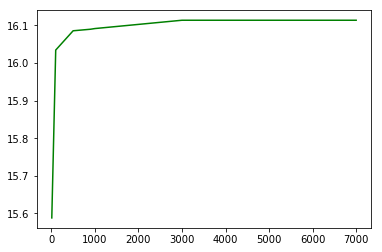

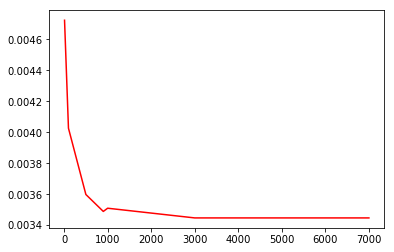

In [523]:
plt.plot([10, 100, 500, 900, 1000, 3000, 5000, 7000], a, label='points', c='g')
plt.show()
plt.plot([10, 100, 500, 900, 1000, 3000, 5000, 7000], b, label='points', c='r')
plt.show()

**Ответ:**

**10. (0.5 балла)** Сформируйте обучающие, валидационные и тестовые матрицы объект-признак для следующих наборов признаков:
 * id пользователя (бинарное кодирование) + id фильма (бинарное кодирование);
 * id пользователя (бинарное кодирование) + id фильма (бинарное кодирование) + средняя оценка пользователя;
 * id пользователя (бинарное кодирование) + id фильма (бинарное кодирование) + жанры фильма;
 * id пользователя (бинарное кодирование) + id фильма (бинарное кодирование) + жанры фильма + киноперсоны.

In [ ]:
# Your code here

**11. (1.5 балла)** Для каждой из выборок из предыдущего пункта постройте рекомендации при помощи факторизационных машин из библиотеки [LibFM](http://libfm.org) с использованием метода оптимизации ALS, подобрав оптимальную размерность разложения на валидационной выборке. Вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке для оптимальных значений гиперпараметров. Какой набор признаков оказался самым удачным? Как это можно объяснить?
При выполнении данного задания вам также может пригодиться библиотека [pywFM](https://github.com/jfloff/pywFM), являющаяся python-обёрткой над LibFM.

In [ ]:
# Your code here

**Ответ:**

**12. (1 балл)** Приведите сравнение качества всех моделей, руководствуясь значениями описанных метрик. Какие из моделей оказались лучше других по каждой из метрик? Как это можно объяснить?

**Ответ**: